In [192]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping

In [193]:
path = './malimg_dataset/'

In [194]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 1 classes.


In [195]:
familias.class_indices

{'malimg_paper_dataset_imgs': 0}

In [196]:
imgs, labels = next(familias)

In [197]:
imgs.shape

(9339, 64, 64, 3)

In [198]:
labels.shape

(9339, 1)

In [199]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

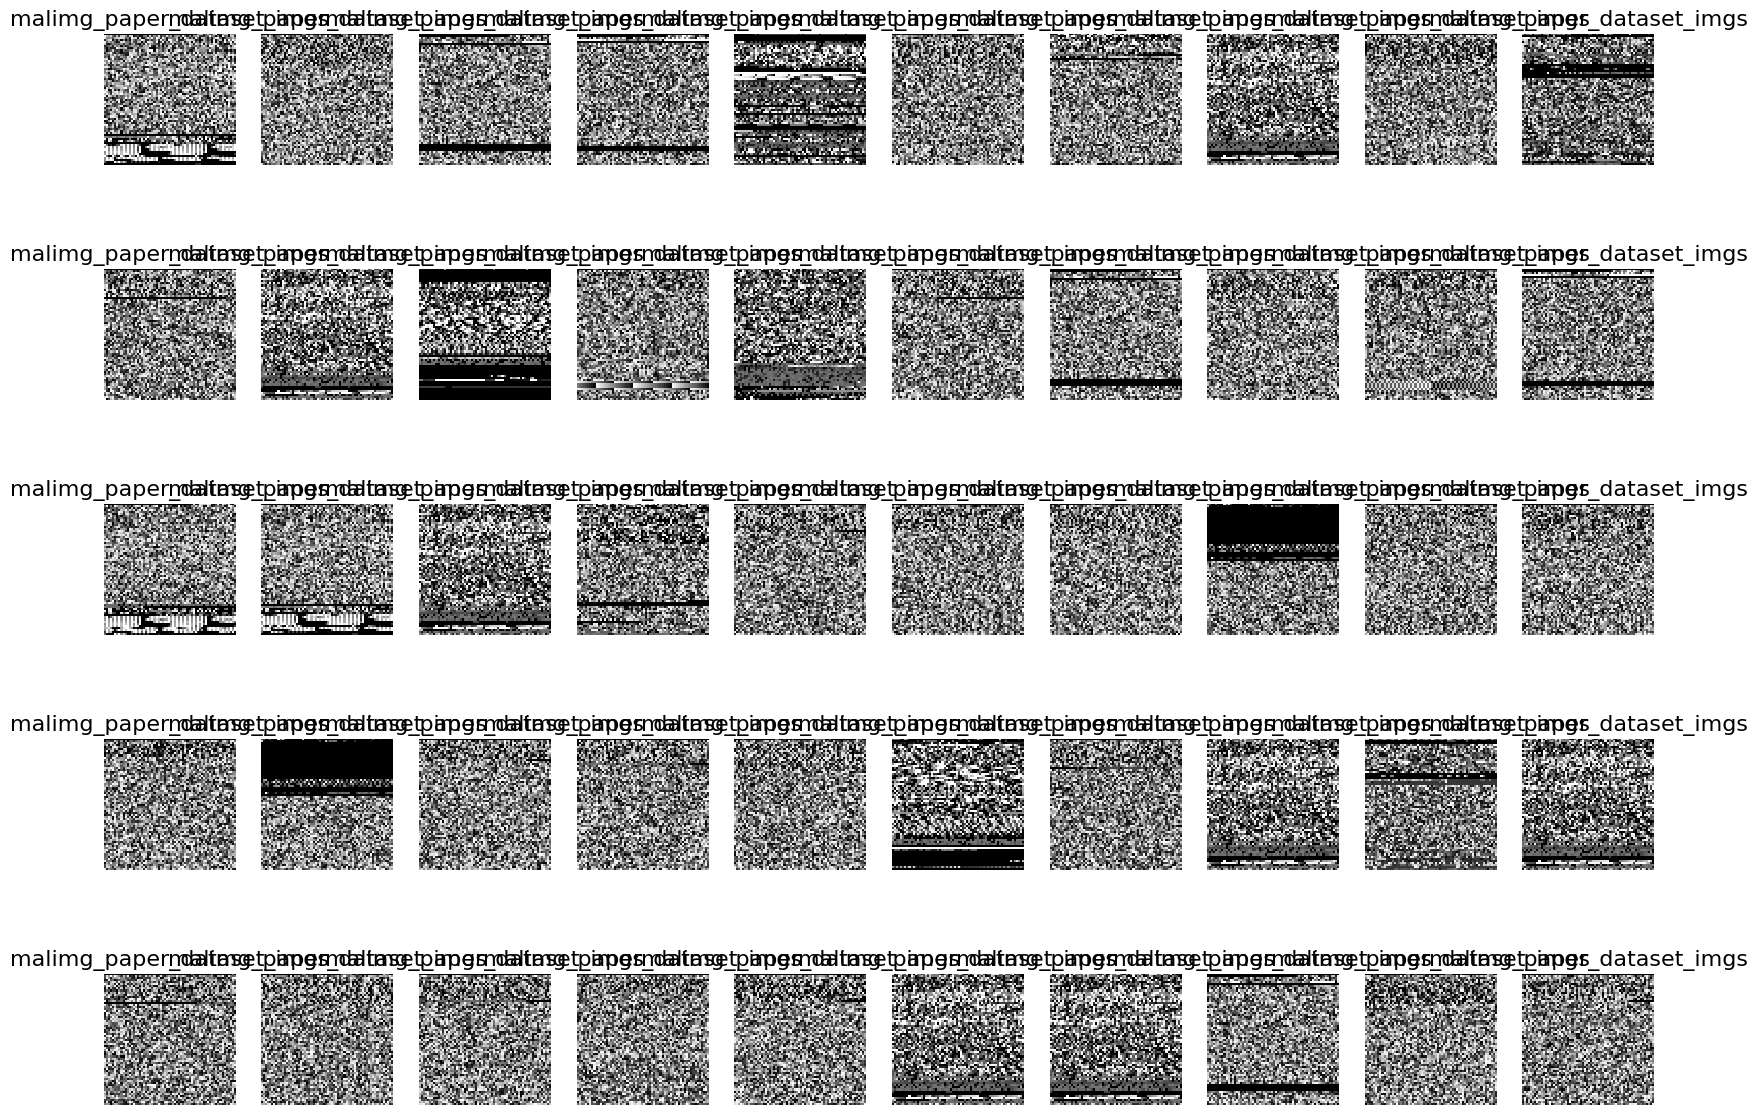

In [200]:

plots(imgs, titles = labels)

Pre preprocesamiento adicional

Conteo de observaciones

In [201]:
# Path al directorio con las imágenes
path = './malimg_dataset/'

# Crear un generador de datos con escalamiento de las imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde el directorio
generator = datagen.flow_from_directory(
    directory=path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Obtener las etiquetas de las clases del generador
class_indices = generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Contar el número de imágenes por clase
for _, labels in generator:
    for label in labels:
        class_name = list(class_indices.keys())[np.argmax(label)]
        class_counts[class_name] += 1
    if generator.batch_index == 0:
        break  # Romper el ciclo después de procesar todas las imágenes una vez

# Mostrar el conteo de cada clase
print("Conteo de observaciones por familia de malware:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Found 9339 images belonging to 1 classes.
Conteo de observaciones por familia de malware:
malimg_paper_dataset_imgs: 9339


Dividiendo la data en 70% train y 30% test

In [202]:
all_images = []
all_labels = []

# Cargando todas las imágenes y etiquetas
for _ in range(generator.samples // generator.batch_size + 1):
    imgs, labels = next(generator)
    all_images.append(imgs)
    all_labels.append(labels)

# Concatenando todas las imágenes y etiquetas en un solo array
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Asegurándose de no tener más datos de los necesarios
all_images = all_images[:generator.samples]
all_labels = all_labels[:generator.samples]

In [203]:
# Dividiendo los datos en un conjunto de entrenamiento y otro de prueba
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)

print(X_train, X_test)

[[[[0.8941177  0.8941177  0.8941177 ]
   [0.00392157 0.00392157 0.00392157]
   [0.27058825 0.27058825 0.27058825]
   ...
   [0.         0.         0.        ]
   [0.07450981 0.07450981 0.07450981]
   [0.00784314 0.00784314 0.00784314]]

  [[0.27450982 0.27450982 0.27450982]
   [0.14117648 0.14117648 0.14117648]
   [0.         0.         0.        ]
   ...
   [0.2901961  0.2901961  0.2901961 ]
   [0.05882353 0.05882353 0.05882353]
   [0.01568628 0.01568628 0.01568628]]

  [[0.5176471  0.5176471  0.5176471 ]
   [0.92549026 0.92549026 0.92549026]
   [0.35686275 0.35686275 0.35686275]
   ...
   [0.3137255  0.3137255  0.3137255 ]
   [0.76470596 0.76470596 0.76470596]
   [0.01568628 0.01568628 0.01568628]]

  ...

  [[0.7137255  0.7137255  0.7137255 ]
   [0.8000001  0.8000001  0.8000001 ]
   [0.         0.         0.        ]
   ...
   [0.41176474 0.41176474 0.41176474]
   [0.43921572 0.43921572 0.43921572]
   [0.47450984 0.47450984 0.47450984]]

  [[0.42352945 0.42352945 0.42352945]
   [0.1

In [204]:
print("Shape of X_train:", X_train.shape)

Shape of X_train: (6537, 64, 64, 3)


In [205]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=3, activation="relu", input_shape=(64, 64, 3)),  
        MaxPooling2D(pool_size=2),
        BatchNormalization(),  # Batch Normalization después de la primera capa de convolución
        Conv2D(64, kernel_size=3, activation="relu"),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),  # Batch Normalization después de la segunda capa de convolución
        Flatten(),
        Dense(128, activation="relu", 
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),  
        Dropout(0.9),  # Ajustando la tasa de dropout
        Dense(10, activation="softmax")
    ])

    # Compilando el modelo con regularización L1 y L2
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [206]:
from keras.utils import to_categorical

# Convertiendo las etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Creando el modelo
model = create_model()

model.fit(X_train, y_train, epochs=5, batch_size=256)

model.save("model.h5")

Epoch 1/5
26/26 [==============================] - 17s 564ms/step - loss: 17.5981 - accuracy: 0.7895
Epoch 2/5
26/26 [==============================] - 15s 564ms/step - loss: 11.8763 - accuracy: 0.9590
Epoch 3/5
26/26 [==============================] - 15s 575ms/step - loss: 6.8092 - accuracy: 0.9830
Epoch 4/5
26/26 [==============================] - 15s 575ms/step - loss: 3.5317 - accuracy: 0.9882
Epoch 5/5
23/26 [=========================>....] - ETA: 1s - loss: 1.9614 - accuracy: 0.9907